# HelloRob Project 4, Part 2: Machine Learning with SciKit Learn

This notebook is part of [HelloRob Project 4](https://hellorob.org/projects/p4). In it, you will use the SciKit Learn library to train and run three machine learning classification algorithms: K-Nearest Neighbors, a Linear Classifier, and a Neural Network.

This part of the project is completed individually. Before submitting the assignment, make sure to run all the cells.

To start, edit the cell below by adding your name.

**Your Name:**

## Imports
Some imports we'll need. Run this cell first.

In [1]:
import os
import time
import gdown
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from keras.datasets import mnist

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

## Helper Functions.

These functions help visualize images and data about them, and load image data. Run this cell before you start.

In [2]:
def make_image_grid(imgs, nrows=1, border_size=2):
    N, H, W = imgs.shape
    ncols = int(np.ceil(N / nrows))
    pad = border_size // 2
    imgs = (imgs * 255 / imgs.max()).astype(np.uint8)
    padded = np.pad(imgs, ((0, 0), (pad, pad), (pad, pad)), 'constant', constant_values=255)
    if N < ncols * nrows:
        _, H, W = padded.shape
        blank = 255 * np.ones((ncols * nrows - N, H, W), dtype=padded.dtype)
        padded = np.concatenate((padded, blank))
    grid = np.vstack([np.hstack(padded[r * ncols:(r + 1) * ncols]) for r in range(nrows)])

    return grid

def confusion_matrix(y_pred, y_true, num_classes):
    confusion = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(num_classes):
        true_i = (y_true == i).nonzero()
        labels, counts = np.unique(y_pred[true_i], return_counts=True)
        confusion[i, labels] = counts

    return confusion

def plot_confusion(confusion, num_classes):
    confusion = confusion / confusion.sum(1)

    plt.imshow(confusion, cmap=plt.get_cmap('viridis'))
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.colorbar()
    plt.xticks(np.arange(num_classes))
    plt.yticks(np.arange(num_classes))

def load_image(path):
    """Load and formant a single image into memory"""
    image = Image.open(path)
    image = ImageOps.grayscale(image)
    image = image.resize((28, 28))
    return 255 - np.asarray(image)

def load_handwritten_images(path):
    """
    Load images from folder
    """
    files = [os.path.join(dirpath,f)
        for (dirpath, _, filenames)
        in os.walk(path)
        for f in filenames]
    images = []
    labels = []
    for file_path in files:
        label = int(file_path.split("/")[-1][0])
        image = load_image(file_path)

        images.append(image)
        labels.append(label)

    images = np.stack(images)
    labels = np.stack(labels)

    return images, labels

## The MNIST Dataset

This cell loads the MNIST dataset. This is the same dataset as in the Nearest Neighbor notebook. This time, we will use the full testing and training dataset.

This time, we will *reshape* the image matrices so that each image is one long vector by lining up each row of the image side by side. This means that instead of having `N` images of size `(H, W)`, we will have `N` *flattened* image vectors of length `H*W`. Our data will consist of these images stacked on top of each other.

The following variables are declared in this cell. Note that the shape of the image data is different than in the Nearest Neighbors notebook because the images are flattened.
* `N_train` and `N_test`: The number of testing and training images
* `width`, `height`, and `DIM`: The width, height, and total number of pixels in the images (note `DIM = width * height`).
* `num_classes`: The number of classes in the dataset (10)
* `x_train`: The training images, with shape `(N_train, DIM)`
* `y_train`: The training labels, a vector of length `N_train`
* `x_test`: The testing images, with shape `(N_test, DIM)`
* `y_test`: The testing labels, a vector of length `N_test`

Each pixel value in the images is a float between 0 and 1. The variables `y_train` and `y_test` contain integers corresponding to the labels for each of the images, between 1 and 10.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 784)
Training labels shape: (60000,)
Testing data shape: (10000, 784)
Testing labels shape: (10000,)


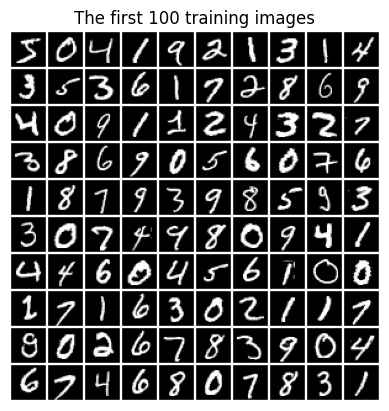

In [3]:
# Number of test and train samples available in MNIST
num_classes = 10

# Load dataset.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert to values from 0 to 1.
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255

# Grab the height and the width from the data.
N_train, width, height = x_train.shape
N_test, = y_test.shape
DIM = width * height

# Flatten the images into long vectors.
x_train = x_train.reshape(N_train, DIM)
x_test = x_test.reshape(N_test, DIM)

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", x_test.shape)
print("Testing labels shape:", y_test.shape)

# Visualize the first 100 training images.
img_grid = make_image_grid(x_train[:100].reshape(-1, width, height), nrows=10)
plt.imshow(img_grid, cmap=plt.get_cmap('gray'))
plt.title("The first 100 training images")
plt.axis('off');  # Adding a semi-colon after the last line stops a print.

## HelloRob Handwriting Dataset

You and your peers have submitted handwriting samples to create our own dataset. By testing on new, unseen data, outside of the MNIST dataset, we can get a better idea of how our algorithms will generalize when we deploy them on our robots. The following cells load the HelloRob Handwriting dataset.

In [4]:
url = "https://drive.google.com/uc?id=1N1Oyi_HGiuGq3UU8XyJdJuwlEhcSHqdW"
output = "hellorob_handwriting.zip"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1N1Oyi_HGiuGq3UU8XyJdJuwlEhcSHqdW
To: /content/hellorob_handwriting.zip
100%|██████████| 3.07M/3.07M [00:00<00:00, 26.1MB/s]


'hellorob_handwriting.zip'

In [5]:
!unzip -q -o /content/hellorob_handwriting.zip

Student data size: (300, 784)
Student labels size: (300,)


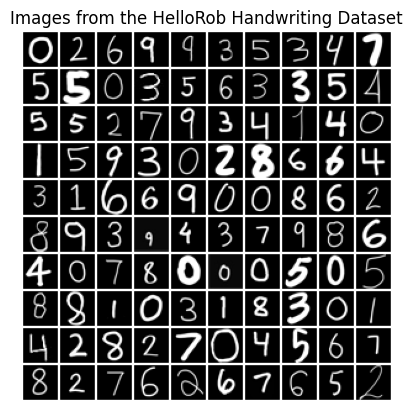

In [6]:
x_hellorob, y_hellorob = load_handwritten_images("/content/hellorob_handwriting")

N_hellorob, = y_hellorob.shape

# Convert to floats between 0 and 1.
x_hellorob = x_hellorob.astype(float) / 255

# Flatten the images into long vectors.
x_hellorob = x_hellorob.reshape(N_hellorob, DIM)

# Shuffle the data.
idx = np.arange(N_hellorob)
np.random.shuffle(idx)
x_hellorob = x_hellorob[idx]
y_hellorob = y_hellorob[idx]

print("Student data size:", x_hellorob.shape)
print("Student labels size:", y_hellorob.shape)

# Display some of the images.
num_viz = min(100, N_hellorob)
img_grid = make_image_grid(x_hellorob[:num_viz].reshape(-1, width, height), nrows=10)
plt.imshow(img_grid, cmap=plt.get_cmap('gray'))
plt.title("Images from the HelloRob Handwriting Dataset")
plt.axis('off');

## K-Nearest Neighbors

First, we will revisit the Nearest Neighbors algorithm. This time, we will use the K-Nearest Neighbors algorithm for image classification. In K-Nearest Neighbors, we let the K nearest images vote for the class of a test image.

*Note*: In Part 1, we implemented a 1-Nearest Neighbor classifier (K = 1).

SciKit Learn contains models for multiple different machine learning algorithms. When each model is created, it takes in various parameters, typically called *hyperparameters*, which affect how the algorithm behaves. The parameters are different for each algorithm.

We will use SciKit Learn's [K-Nearest Neighbor classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to do this. We will create a model called `knn`. We will consider one hyperparameter, `K`, which is the number of neighbors to compare against.

Run this cell to create the `knn` model:

In [7]:
K = 1  # We will tune this parameter later.
knn = KNeighborsClassifier(K)

All SciKit Learn's machine learning algorithms have two steps:

1.   Train the model,
2.   Predict labels for new images.

SciKit Learn models have a function called `fit` which trains the model using gradient descent, given training data and testing data. For a model called `my_model`, training looks like this:
```python
my_model.fit(x_train, y_train)
```

**Warning:** This might take a long time!

The next step is to predict, which is done with the `predict` function, as follows:
```python
y_pred = my_model.predict(x_test)
```

The models also have function `score`, which does the prediction and computes the accuracy in one step, given the correct class labels:
```python
acc = my_model.score(x_test, y_test)
```

### Training K-Nearest Neighbors

Let's train the K-nearest neighbors algorithm now.

Remember, "training" nearest neighbors just means saving all the training data to compare to when we get a test image. This should run quickly.

In [8]:
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

### Testing K-Nearest Neighbors

Now, we will test the accuracy of the nearest neighbors algorithm. We will do this on both the test set and the training set. We will also time how long it takes the function to run using Python's `time` library.

The accuracy should be pretty high on the testing dataset (above 96%), but it should take a while to run (~30 seconds). What do you expect the training accuracy to be?

In [9]:
# Compute the accuracy on the test set.
start = time.time()  # Save the start time.
acc = knn.score(x_test, y_test)  # Testing accuracy.

print("K-NN Testing Accuracy:", acc)
print("Ran in", time.time() - start, "seconds.")

# Compute the accuracy on the training set.
start = time.time()  # Save the start time.
acc = knn.score(x_train, y_train)  # Training accuracy.

print("K-NN Training Accuracy:", acc)
print("Ran in", time.time() - start, "seconds.")

K-NN Testing Accuracy: 0.9691
Ran in 38.99235653877258 seconds.
K-NN Training Accuracy: 1.0
Ran in 239.14811301231384 seconds.


It is useful to get a bit more information about our algorithm, besides the accuracy. Which images are getting misclassified?

In the next cell, we will get predictions for the test data and visualize the confusion matrix.

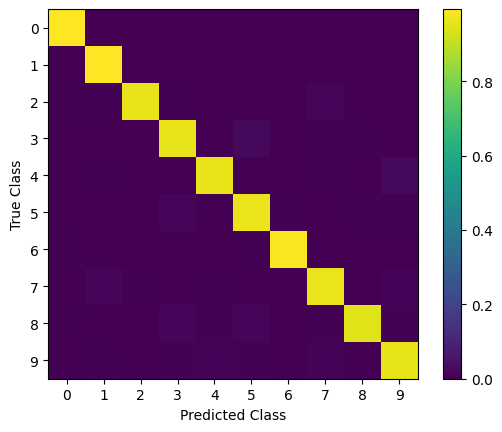

In [10]:
y_pred = knn.predict(x_test)
confusion = confusion_matrix(y_pred, y_test, num_classes)

# Plot the confusion matrix as an image.
plot_confusion(confusion, num_classes)

### HelloRob Handwriting Dataset

Let's try running the algorithm on the handwriting dataset we created.

In [11]:
# Compute the accuracy on the test set.
start = time.time()  # Save the start time.
acc = knn.score(x_hellorob, y_hellorob)  # Testing accuracy.

print("K-NN Accuracy on HelloRob Dataset:", acc)
print("Ran in", time.time() - start, "seconds.")

K-NN Accuracy on HelloRob Dataset: 0.5433333333333333
Ran in 1.1546478271484375 seconds.


We can also compute the confusion matrix for the custom dataset.

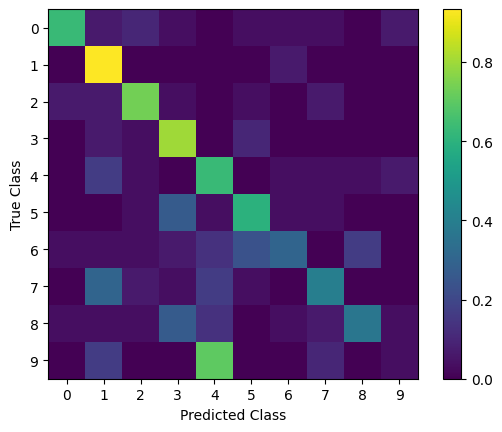

In [12]:
y_pred = knn.predict(x_hellorob)
confusion = confusion_matrix(y_pred, y_hellorob, num_classes)

# Plot the confusion matrix as an image.
plot_confusion(confusion, num_classes)

Let's print out some images and their labels:

Img 0 -> Predicted: 4 True: 9
Img 1 -> Predicted: 1 True: 1
Img 2 -> Predicted: 3 True: 3
Img 3 -> Predicted: 2 True: 2
Img 4 -> Predicted: 0 True: 8
Img 5 -> Predicted: 5 True: 5
Img 6 -> Predicted: 2 True: 2
Img 7 -> Predicted: 8 True: 8
Img 8 -> Predicted: 7 True: 7
Img 9 -> Predicted: 4 True: 8


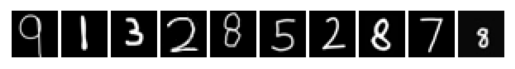

In [13]:
num_viz = 10

idx = np.random.choice(np.arange(N_hellorob), num_viz, replace=False)
imgs = x_hellorob[idx, :]

for i in range(0, num_viz):
    img = idx[i]
    print("Img", i, "-> Predicted:", y_pred[img], "True:", y_hellorob[img])

img_grid = make_image_grid(imgs.reshape(-1, width, height), nrows=1)
plt.imshow(img_grid, cmap=plt.get_cmap('gray'))
plt.axis('off');

### Tuning Hyperparameter `K`

We used a value of `K = 1`, which is the same algorithm we implemented in the first notebook. Is there a better value of `K`? Let's find out!

To start, try changing the value of `K` in the following cell. Run the cell a few times with different values and see how the accuracy changes.

In [14]:
K = 0  # TODO: Change K to a different value.
knn = KNeighborsClassifier(K)
knn.fit(x_train, y_train)

acc = knn.score(x_test, y_test)  # Testing accuracy.
print("Testing accuracy for K =", K, ":", acc)

InvalidParameterError: The 'n_neighbors' parameter of KNeighborsClassifier must be an int in the range [1, inf) or None. Got 0 instead.

Let's try testing the training accuracy for the same value of `K`. Should it be higher or lower than for `K = 1`?

In [ ]:
train_acc = knn.score(x_train, y_train)  # Training accuracy.
print("Training accuracy for K =", K, ":", train_acc)

### Tuning `K` with Cross Validation

In lecture, we learned about a method for choosing hyperparameters called cross validation. In the next cell, we split up our training set into a validation set and a smaller training set to use for hyperparameter tuning. We will use the validation set to choose the hyperparameter `K`.

In [ ]:
N_valid = 10000  # Size of validation set.

# Choose random indices for the validation set.
indices = np.arange(N_train)
np.random.shuffle(indices)
train_idx, valid_idx = indices[:N_valid], indices[N_valid:]

# Create small train and validation set.
x_train_small, y_train_small = x_train[train_idx, :], y_train[train_idx]
x_valid, y_valid = x_train[valid_idx, :], y_train[valid_idx]

print("New training data shape:", x_train_small.shape)
print("New training labels shape:", y_train_small.shape)
print("Validation data shape:", x_valid.shape)
print("Validation labels shape:", y_valid.shape)

Now you will run cross validation to select the best value of `K`. Fill the list `ks` with the values of `K` you would like to evaluate. Then, for each value, calculate the accuracy on the validation set. Store the accuracy in `accuracies`.

You should fit the model using `x_train_small` and `y_train_small`, and score the model by testing on `x_valid` with labels `y_valid`. *Do not use `x_test` and `y_test` during cross validation!*

*Hint:* You will need to create a new model, `knn`, for each different value in `ks`, and call the fit function again. This should look like lines 2 and 3 in the section "Tuning Hyperparameter K".

*Hint:* The MNIST training data contains lots of images that look very similar, so `K = 1` often does pretty well. However, this won't generalize very well. You might want to ignore `K = 1`.

*Note:* You can tune even better by implementing k-fold cross validation! You may use either k-fold cross validation, or implement the method with one fold. For k-fold cross validation, you can split the training images and labels into folds with [NumPy's split function](https://numpy.org/doc/stable/reference/generated/numpy.split.html?highlight=split#numpy.split), by doing `folds = np.split(x_train, num_folds)`, for example.

In [ ]:
# Put the values of K you will test in the list below.
ks = []
accuracies = []

# TODO: For each value in `ks`, compute the accuracy of the algorithm on the
# validation set. Add the accuracy to the list `accuracies`.

This next block plots the accuracy for each value of `K` tested.

In [ ]:
plt.plot(ks, accuracies)
plt.title("K vs. Accuracy for K-Nearest Neighbors")
plt.grid()

Based on the result of your hyperparameter tuning, choose the best `K`. You can do this by inspection, or use code to pick the best `K` from the list `ks` based on `accuracies`.

To get the final accuracy, we use the full training set to train the algorithm, and test using the testing set.

In [ ]:
# TODO: Save the best value of K in best_k.
best_k = None

knn = KNeighborsClassifier(best_k)
knn.fit(x_train, y_train)
acc = knn.score(x_test, y_test)
print("Accuracy for K =", best_k, ":", acc)

In [ ]:
y_pred = knn.predict(x_test)
confusion = confusion_matrix(y_pred, y_test, num_classes)

# Plot the confusion matrix as an image.
plot_confusion(confusion, num_classes)

Finally, let's see how this performs on the HelloRob Handwriting Dataset.

In [ ]:
acc = knn.score(x_hellorob, y_hellorob)
print("Accuracy for K =", best_k, ":", acc)

In [ ]:
y_pred = knn.predict(x_hellorob)
confusion = confusion_matrix(y_pred, y_hellorob, num_classes)

# Plot the confusion matrix as an image.
plot_confusion(confusion, num_classes)

## Linear Classifier

Our next algorithm is a linear classifier (or a Linear Support Vector Machine). SciKit Learn does not expose very many hyperparameters for this one. We will train the algorithm using the standard options.

This will be our baseline to compare with the Neural Network.

If you would like to see all the hyperparameters and try tuning them, see the [model documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html).

First, we create the model, and call the fit function to train it.

We will also time how long it takes to train. It will take a lot longer than the K-Nearest Neighbor model (many minutes)!

In [ ]:
linear_cls = LinearSVC(max_iter=5000)  # You can increase max_iters if fit doesn't converge.

start = time.time()
linear_cls.fit(x_train, y_train)
print("Linear classifier training time:", time.time() - start, "seconds")

Next, we will check the model's accuracy on both the testing and training data. We will also time this function. It should be a lot faster than K-Nearest Neighbor to test all 10,000 images. The accuracy should be just over 90% on the testing data.

In [ ]:
start = time.time()
acc = linear_cls.score(x_test, y_test)
print("Testing Accuracy:", acc)
print("Linear classifier testing time (test data):", time.time() - start, "seconds")

start = time.time()
acc = linear_cls.score(x_train, y_train)
print("\nTraining Accuracy:", acc)
print("Linear classifier testing time (train data):", time.time() - start, "seconds")

start = time.time()
acc = linear_cls.score(x_hellorob, y_hellorob)
print("\nHelloRob Accuracy:", acc)
print("Linear classifier testing time (HelloRob data):", time.time() - start, "seconds")

Next, let's compute and visualize the confusion matrix for the linear classifier.

In [ ]:
y_pred = linear_cls.predict(x_test)
confusion = confusion_matrix(y_pred, y_test, num_classes)

# Plot the confusion matrix as an image.
plot_confusion(confusion, num_classes)

## Two-Layer Neural Network

Next, we will implement a two-layer neural network. We will be using a fully-connected neural network model, as discussed in lecture, which is also called a *Multi-Layer Perceptron* (MLP). This is implemented in `MLPClassifier` in SciKit Learn ([link](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)).

There are a few hyperparameters to tune this time. The most important ones are the learning rate, `lr`, and the hidden layer size, `hidden_dim`. You can also optionally tune the regularization coefficient, `alpha`, but it has less impact than the other two.

Run the cell below to train the neural network, and the next cell to check the training and testing accuracy. Then, try changing the parameters and running it again.

In [ ]:
alpha = 1e-6  # You can leav this value as is if you would like.
lr = 1e-1
hidden_dim = 64

neural_net = MLPClassifier(alpha=alpha,
                           learning_rate_init=lr,
                           hidden_layer_sizes=(hidden_dim,),
                           max_iter=2000)

start = time.time()
neural_net.fit(x_train, y_train)
print("Training time:", time.time() - start, "seconds")

In [ ]:
# Test accuracy
start = time.time()
acc = neural_net.score(x_test, y_test)
print("Testing Accuracy:", acc)
print("Prediction time (test data):", time.time() - start, "seconds")

# Training accuracy
start = time.time()
acc = neural_net.score(x_train, y_train)
print("Training Accuracy:", acc)
print("Prediction time (train data):", time.time() - start, "seconds")

In [ ]:
# Plot confusion matrix
y_pred = neural_net.predict(x_test.reshape(N_test, -1))
confusion = confusion_matrix(y_pred, y_test, num_classes)
plot_confusion(confusion, num_classes)

### Cross Validation

Now, we will perform cross validation to pick the hyperparameters. You should use cross validation to select the learning rate `lr` and hidden layer size, `hidden_dim`. You may also search for the best regularization coefficient `alpha`, or keep it constant.

This time, since there two values to choose, we will store the accuracy for each combination in a matrix and pick the best. The accuracy associated with learning rate `i` and hidden dimension `j` should be stored at `accuracies[i, j]`.

*Hint:* The hidden dimension passed to the algorithm as `hidden_layer_sizes` must be a tuple, even though it will only be one number. You can make a tuple with one number by doing `(num,)`.

*Hint:* Good starting values for the hidden dimension are between around 10 and 500. Good starting values for the learning rate are between $1\times10^{-4}$ and 1. You might want to start off with a coarse search, then do a fine search near the best looking values.

**Warning:** This will take a while to run!

In [ ]:
# TODO: Put the values for the learning rate and hidden dimension you will test
# in the lists below.
lrs = []
hidden_dims = []
accuracies = np.zeros((len(lrs), len(hidden_dims)))

for i in range(len(lrs)):
    for j in range(len(hidden_dims)):
        # TODO: For each learning rate and hidden dimension pair, train a
        # neural network on the small training data, then compute the accuracy
        # of the model on the validation set. Store the accuracy in `accuracies`.
        pass  # Replace this with your code.

Let's visualize the grid of accuracies for the combination of hyperparameters as a heatmap.

In [ ]:
lr_pts, hd_pts = np.meshgrid(lrs, hidden_dims)
lr_pts, hd_pts = lr_pts.flatten(), hd_pts.flatten()
plt.scatter(lr_pts, hd_pts, 100, c=accuracies.flatten(), cmap='viridis')
plt.colorbar()
plt.xticks(lrs)
plt.yticks(hidden_dims);

Now, pick the best learning rate and hidden layer dimension, and test the accuracy on the test set and the custom class dataset. You can do this with code or by observation.

In [ ]:
# TODO: Set these hyperparameters based on the result of your cross validation.
best_lr, best_hidden = None, None

neural_net = MLPClassifier(alpha=alpha,
                           learning_rate_init=best_lr,
                           hidden_layer_sizes=(best_hidden,),
                           max_iter=2000)
neural_net.fit(x_train, y_train)

Test your best neural network on the testing, training, and HelloRob datasets.

Your neural network must do better than the linear classifier on the test dataset. You should be able to get at least 95% accuracy on the test set.

*Note:* How does the neural network do on the HelloRob Handwriting dataset compared to the k-NN or the linear classifier? What does this suggest about the performance on robot images?

In [ ]:
# Test accuracy
start = time.time()
acc = neural_net.score(x_test, y_test)
print("Testing Accuracy:", acc)
print("Prediction time (test data):", time.time() - start, "seconds")

# Training accuracy
start = time.time()
acc = neural_net.score(x_train, y_train)
print("\nTraining Accuracy:", acc)
print("Prediction time (train data):", time.time() - start, "seconds")

# HelloRob accuracy
start = time.time()
acc = neural_net.score(x_hellorob, y_hellorob)
print("\nHelloRob Dataset Accuracy:", acc)
print("Prediction time (HelloRob data):", time.time() - start, "seconds")

## Export the Model

Now that you have trained your model, export your favorite by replacing `my_model` below with your trained model. This should be the model after it is created and trained. Make sure you rerun the final testing cell for the model, after cross validation, on the whole training dataset, before running this cell.

In [ ]:
from joblib import dump
dump(neural_net, 'model.joblib');

In the left-hand panel of the notebook, click the "Files" icon. Then, find the file "model.joblib", select the three dots beside the file name, and select "Download." This will be the file you use to run your trained model on the robot.

## Testing Ground!

Curious about any other algorithms? Or interested in trying different neural network architectures? Feel free to experiment by adding cells below. For example, you can try out a three-layer neural network by providing two hidden dimensions, `(hidden_dim1, hidden_dim2)`.

If you choose an algorithm outside of the ones we have tested above, make sure that the code to train and test it, and the resulting accuracy, is clearly shown.

In [ ]:
# Write more code here, if you would like!